In [1]:
#%matplotlib inline
import os
import sys
AbsPath = os.path.abspath("")
sys.path.append(AbsPath+"/../..")
import pickle
import numpy as np
import pandas as pd
import scipy
import importlib
from numba import jit
from scipy.interpolate import interp1d as int1d
from scipy import interpolate
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy
from colossus.cosmology import cosmology
import colossus.halo.mass_adv as massdefs
from colossus.halo.mass_defs import changeMassDefinition as CMD
from colossus.halo.concentration import concentration as conc
from colossus.lss import mass_function
from colossus.halo.mass_so import M_to_R
from halotools import empirical_models
from Functions import Functions as F
cosmology.setCosmology("millennium")#'planck15')
Cosmo = cosmology.getCurrent()
HMF_fun = F.Make_HMF_Interp() #N Mpc^-3 h^3 dex^-1
h = Cosmo.h
h_3 = h*h*h
#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)


#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}

AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False,\
'HMevo': False,\
'HMevo_param': None\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}

#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.titlepad'] = 20

plt.rcParams['font.size']=15

@jit#('double[:,:],double[:,:],double[:,:](double[:,:,:],double[:,:,:], double[:],double[:])')
def JitLoop(SHMF_Entering, Mass_Ratio_Bins, z_step, t_step, SatHaloBin):
    m, n, o = np.shape(SHMF_Entering)
    Accreted_Above_Ratio = np.zeros((m, n))
    Accreted_Above_Ratio_dz = np.zeros((m, n))
    Accreted_Above_Ratio_dt = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            Accreted_Above_Ratio[i,j] = np.sum(SHMF_Entering[i, j,Mass_Ratio_Bins[i,j]:])*SatHaloBin
            Accreted_Above_Ratio_dz[i,j] = np.sum(SHMF_Entering[i, j,Mass_Ratio_Bins[i,j]:])*SatHaloBin/z_step[i]
            Accreted_Above_Ratio_dt[i,j] = np.sum(SHMF_Entering[i, j,Mass_Ratio_Bins[i,j]:])*SatHaloBin/t_step[i]
    return Accreted_Above_Ratio, Accreted_Above_Ratio_dz, Accreted_Above_Ratio_dt

/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [2]:
importlib.reload(F)

<module 'Functions.Functions' from '/data/pg1g15/STEEL/Notebooks/Tests/../../Functions/Functions.py'>

In [10]:
#AvaHaloMass_wz = np.loadtxt(AbsPath+"/../../Data/Model/Input/11.016.60.050.6774.dat"); HighRes = True
#AvaHaloMass_wz = np.loadtxt(AbsPath+"/../../Data/Model/Input/11.016.60.10.6774.dat"); HighRes = False

#AvaHaloMass_wz = np.loadtxt(AbsPath+"/../../Data/Model/Input/11.016.60.050.73.dat"); HighRes = True
AvaHaloMass_wz = np.loadtxt(AbsPath+"/../../Data/Model/Input/11.016.60.10.73.dat"); HighRes = False

z = AvaHaloMass_wz[:,0]
AvaHaloMass = AvaHaloMass_wz[:,1:]
z_Cut_Bin = np.digitize(0.1, bins = z)
z, AvaHaloMass = z[z_Cut_Bin:], AvaHaloMass[z_Cut_Bin:]
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)
if HighRes:
    SatHaloBin = 0.05
    SatHaloMass = np.arange(np.min(AvaHaloMass[0])-3, np.max(AvaHaloMass[0])-0.1, SatHaloBin)
else:
    SatHaloBin = 0.1
    SatHaloMass = np.arange(np.min(AvaHaloMass[0])-1, np.max(AvaHaloMass[0])-0.1, SatHaloBin) 

In [11]:
#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}
a, b = np.shape(AvaHaloMass)
c = np.size(SatHaloMass)
#Make  m_M to FOR uSHMF from Jing et al
m_M = np.array([[SatHaloMass - AvaHaloMass[i][j] for j in range(b)] for i in range(a)])
#Create SHMF arrays (no redshift evolution)
SHMFs = np.array([[F.dn_dlnX(Unevolved, np.power(10, m_M[i][j]))\
                   for j in range(b)] for i in range(a)])
#Calculate the number density of halos that fall in at each timestep
SHMF_Entering = np.array([[SHMFs[:, i][j] - SHMFs[:, i][j+1] for i in range(b)] for j in range(a-1)])

z_step = z[1:] - z[:-1]
t_step = Cosmo.age(z[:-1]) - Cosmo.age(z[1:])
Mass_Ratio_Limit = AvaHaloMass + np.log10(0.3)
Mass_Ratio_Bins = np.digitize(Mass_Ratio_Limit, bins = SatHaloMass)[:-1]
Accreted_Above_Ratio, Accreted_Above_Ratio_dz, Accreted_Above_Ratio_dt =  JitLoop(SHMF_Entering, Mass_Ratio_Bins, z_step, t_step, SatHaloBin)


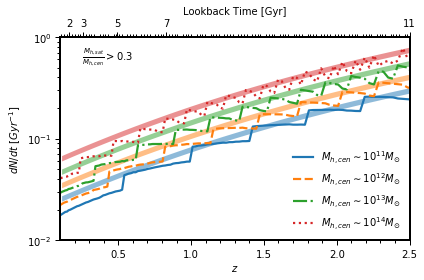

In [12]:
def u_func(x):
    return np.log(1+x) - np.divide(x, 1+x)

def fof_to_mcrit(b, C):
    nc = 0.653
    crit = 3*nc*np.power(b,-3)*np.divide(u_func(C)*np.power(1+C ,2), np.power(C,2)) -1
    return f'{crit:.0f}'+'c'


def FakMaIntegrand(e):
    e_bar = 9.72*(10**-3);beta=-1.995;gamma=0.263;
    return np.power(e, beta)*np.exp(np.power((e/e_bar),gamma))
def FakMa_MergerRate(Mvir, z, e = 0.3):
    Mfof = []
    for i, zi in enumerate(z):
        C = conc(Mvir, 'vir', zi)
        Mfof.append(CMD(Mvir, C, zi, 'vir', fof_to_mcrit(0.2, C))[0])
    Mfof = np.array(Mfof)
    A = 0.0104; alpha = 0.133;nu=0.0993
    return A*np.power(((Mfof)/10**12), alpha)*np.power(1+z, nu)*scipy.integrate.quad(FakMaIntegrand, e, 1)[0]


fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twiny()#add time axis on top

lines = ["-", "--", "-.", ":"]
linecycler = cycle(lines)
colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "k"]
colourcycler = cycle(colours)
for j, M0 in enumerate([11, 12, 13, 14]):
    colour = next(colourcycler)
    line = next(linecycler)
    Y_dt = []
    X = []
    for i in range(len(z[:-1])):
        try:
            M0_bin_zi = np.digitize(M0, bins = AvaHaloMass[i]) -1
            Y_dt.append(Accreted_Above_Ratio_dt[i,M0_bin_zi])
            X.append(z[i])
        except Exception as e1:
            try:
                #Attempt to smooth the array
                Temp = AvaHaloMass[i]
                Temp2 = Temp
                for j, Mip1 in enumerate(Temp[1:]):
                    if Temp[j] > Mip1:
                        Temp2[j+1] = np.log10((np.power(10,Temp[j])+np.power(10,Temp[j+2]))/2)

                M0_bin_zi = np.digitize(M0, bins = Temp2) -1
                Y_dt.append(Accreted_Above_Ratio_dt[i,M0_bin_zi])
                X.append(z[i])
            except Exception as e2:
                """
                print(e1)
                print(e2)
                print(z[i])
                print(AvaHaloMass[i])
                print(Temp2)
                #"""
                break
    ax.plot(X, np.array(Y_dt), line, label = r"$M_{h, cen} \sim$"+"$10^{%s}$"%M0+r"$M_{\odot}$", color = colour, linewidth = 2.2)
    ax.fill_between(z[1:], FakMa_MergerRate(10**(M0-0.2), z[1:])*(z_step/t_step), FakMa_MergerRate(10**(M0+0.2), z[1:])*(z_step/t_step), alpha = 0.5)
ax.set_yscale('log')
ax.set_ylim(0.01, 1)
ax.set_xlim(0.1, 2.5)
ax2.set_xlim(ax.get_xlim())
#Extra ticks
upper_x_tick_loc = [Cosmo.lookbackTime(2, inverse = True), Cosmo.lookbackTime(3, inverse = True), Cosmo.lookbackTime(5, inverse = True), Cosmo.lookbackTime(7, inverse = True), Cosmo.lookbackTime(11, inverse = True)]
ax2.set_xticks(upper_x_tick_loc)
ax2.set_xticklabels([2,3,5,7,11])
ax2.set_xlabel("Lookback Time [Gyr]")
#ax2.minorticks_off()
ax.set_xlabel("$z$")
ax.set_ylabel("$dN/dt$ $[Gyr^{-1}]$")
ax.text(0.25, 0.6, r"$\frac{M_{h, sat}}{M_{h,cen}} > 0.3$")
ax.legend(loc = 4, frameon = False)
plt.tight_layout()
#plt.savefig("./PaperTwoPlotData/HaloMergerRate.png")
#plt.savefig("./PaperTwoPlotData/HaloMergerRate.pdf")
plt.show()